# Arrival Time Prediction - Pre Processing
This notebook is the first on the work on GP regression for arrival time prediction and deals with the pre processing before a model can be trained to make predictions.

First off lets get some libraries into scope and load the data.

In [3]:
import numpy as np
import pandas as pd
import time
import pickle
from datetime import datetime
from functools import reduce
import plot

data = pd.read_csv('./bus203_all.csv')
data = data[data.journey_number < 10]
data.head()

,Unnamed: 0,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number
0,0,2018-02-16T04:48:40.0000000+01:00,JourneyStartedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,NaN,1,1
1,1,2018-02-16T04:48:40.0000000+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1
2,2,2018-02-16T04:48:40.0000000+01:00,ArrivedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,Rydsv\xe4gens \xe4ndh\xe5llpl.,1,1
3,3,2018-02-16T04:48:41.0000000+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1
4,4,2018-02-16T04:48:42.0000000+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1


The names in the csv are very verbose, so we'll shorten them. This is of course a matter of preference but I prefer it this way.

In [4]:
data = data.rename(columns = {
                        'latitude': 'lat', 
                        'longitude': 'lon', 
                        'journey_number': 'traj', 
                        'segment_number': 'seg', 
                        'speed': 'speed',
                        'event': 'event',
                        'timestamp': 'timestamp'
                    })
data.head()
data = data.sort_values(['traj', 'seg', 'timestamp'])

## Stop Compression
There are many times where busses stop or drive very slowly. This causes a lot of data points to be clustered which will cause the GPs to prioritise getting the clustered areas right more than other areas, which we do not want. To prevent this we will filter out data points in every trajectory that are too close by some delta. However simply throwing the points aray will leave massive gaps in between them, which will not work at all for a GP with constant kernel lengthscale (which we will use). To combat this we will compress the data points during stops to a single data point which takes the mean value.

Worth noting is that coordinates are not in euclidian space but on a spherical surface so pythagoras theorem is no good here and we have to turn to haversine distance.

In [41]:
from math import radians, cos, sin, asin, sqrt, isnan
 
def parse_time(dt_str):
    dt, _, _ = dt_str.partition(".")
    return datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")
 
def haversine(lon1, lat1, lon2, lat2):
    """
   Calculate the great circle distance between two points
   on the earth (specified in decimal degrees)
   """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers
    return c * r
 
def as_dict(d):
    return {
        'lat': d.lat,
        'lon': d.lon,
        'seg': d.seg,
        'speed': d.speed,
        'traj': d.traj,
        'timestamp': d.timestamp,
        'event': d.event
    }

# I have no idea why, but this consistently returns one hour too much.
# Also, we actually call to_datetime twice (one more time outside of the function)
# which seems to be needed. No clue why this is the case.
def mean_timestamp(timestamps):
    dt = pd.to_datetime(timestamps.dropna().astype(np.int64).mean())
    dt = dt - pd.Timedelta(hours=1)
    return dt
 
def compress(data):
    dict_data = [as_dict(x) for x in data]
   
    if len(dict_data) == 1: return dict_data[0]
   
    df = pd.DataFrame(dict_data)
   
    speed = np.mean(df.speed[df.speed >= 0])
 
    df2 = df.drop(['timestamp', 'event', 'seg', 'speed'], axis=1).apply(np.mean, axis=0)
    df2['timestamp'] = mean_timestamp(df['timestamp'].apply(parse_time))
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
    df2['speed'] = speed
   
    contains_entered_event = lambda df : df.event.transform(lambda e : e == 'EnteredEvent').any()
    df2['event'] = 'EnteredEvent' if contains_entered_event(df) else 'ObservedPositionEvent'
    df2['seg'] = df.seg.min() # In the case of overlapping segments we let the data belong to the first
 
    return as_dict(df2)
   
t0 = time.time()
delta = 4e-3 # approx. 4 metres
output = []
buffer = [ data.iloc[0] ]
for current in data.itertuples():
    if current.Index == 0: continue
       
    distance = haversine(current.lat, current.lon, buffer[-1].lat, buffer[-1].lon)
   
    if distance > delta:
        output.append(compress(buffer))
        buffer.clear()
   
    buffer.append(current)

if len(buffer) > 0: 
    output.append(compress(buffer))

compressed_data = pd.DataFrame(output)
 
elapsed = time.time() - t0
print("Data processed in", elapsed, " seconds")
compressed_data

Data processed in 2.392693042755127  seconds


,event,lat,lon,seg,speed,timestamp,traj
0,ObservedPositionEvent,15.571012,58.414258,1,0.000000,2018-02-16 03:48:46.176470784,1.0
1,DepartedEvent,15.571187,58.414196,1,-1.000000,2018-02-16 03:48:54.000000000,1.0
2,ObservedPositionEvent,15.571246,58.414280,1,2.315909,2018-02-16 03:49:05.304347648,1.0
3,ObservedPositionEvent,15.571079,58.414436,1,4.370000,2018-02-16 03:49:17.000000000,1.0
4,ObservedPositionEvent,15.570891,58.414459,1,6.730000,2018-02-16 03:49:18.000000000,1.0
5,ObservedPositionEvent,15.570773,58.414478,1,7.300000,2018-02-16 03:49:19.000000000,1.0
6,ObservedPositionEvent,15.570651,58.414497,1,8.020000,2018-02-16 03:49:20.000000000,1.0
7,ObservedPositionEvent,15.570508,58.414520,1,8.790000,2018-02-16 03:49:21.000000000,1.0
8,ObservedPositionEvent,15.570354,58.414547,1,9.150000,2018-02-16 03:49:22.000000000,1.0
9,ObservedPositionEvent,15.570197,58.414577,1,9.670000,2018-02-16 03:49:23.000000000,1.0


## Computing arrival times
The goal is to estimate arrival time given a trajectory, but to do that we first need to annotate the trajectories in the data with the actual arrival times. We do this by first creating a dictionary which maps trajectories to arrival times and save it for later. This will be used to annotate each data point.

In [4]:
def parse_time(dt_str):
    dt, _, _ = dt_str.partition(".")
    return datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")

def traj_travel_time(data, traj):
    traj_data = data[data.traj == traj]
    segs = traj_data.seg.unique()
    return {seg : seg_travel_time(traj_data, seg) for seg in segs}

def seg_travel_time(traj_data, seg):
    seg_data = traj_data[traj_data.seg == seg].sort_values('timestamp')
    start_time = seg_data.iloc[0].timestamp # parse_time(seg_data.iloc[0].timestamp)
    arrival_time = seg_data.iloc[-1].timestamp #parse_time(seg_data.iloc[-1].timestamp)
    return arrival_time - start_time

t0 = time.time()
trajs = compressed_data.traj.unique()
travel_times = {traj : traj_travel_time(compressed_data, traj) for traj in trajs}
elapsed = time.time() - t0
print("Data processed in", elapsed, " seconds")
travel_times
#with open('travel_times.pkl', 'wb') as handle:
#    pickle.dump(travel_times, handle, protocol=pickle.HIGHEST_PROTOCOL)


Data processed in 0.18064427375793457  seconds


{1.0: {1: Timedelta('0 days 00:01:05.823529'),
  2: Timedelta('0 days 00:00:44.187500'),
  3: Timedelta('0 days 00:00:40'),
  4: Timedelta('0 days 00:00:40.200000'),
  5: Timedelta('0 days 00:00:50'),
  6: Timedelta('0 days 00:01:05.647058'),
  7: Timedelta('0 days 00:01:03'),
  8: Timedelta('0 days 00:00:24.666666'),
  9: Timedelta('0 days 00:02:02'),
  10: Timedelta('0 days 00:00:39'),
  11: Timedelta('0 days 00:00:36')},
 2.0: {1: Timedelta('0 days 00:02:07.455882'),
  2: Timedelta('0 days 00:00:55.806451'),
  3: Timedelta('0 days 00:00:56.187500'),
  4: Timedelta('0 days 00:00:54'),
  5: Timedelta('0 days 00:00:56'),
  6: Timedelta('0 days 00:01:12.312500'),
  7: Timedelta('0 days 00:01:22.249999'),
  8: Timedelta('0 days 00:00:47'),
  9: Timedelta('0 days 00:02:17.149999'),
  10: Timedelta('0 days 00:01:12.473684'),
  11: Timedelta('0 days 00:00:45')},
 3.0: {1: Timedelta('0 days 00:02:06.397052'),
  2: Timedelta('0 days 00:00:40'),
  3: Timedelta('0 days 00:01:17.904762'),
  4: T

Now let's annotate the data. In this case we are going to add a field for "time remaining". In addition we are going to need to know the _progression_ of each trajectory, which is computed by normalising the temporal progression. This is needed to train a synchronisation GP before making the predictions. Observe that this is done after stop compression, which means that we assume that the information lost on how long a trajectory is spatially stationary is irrelevant for our predictions. The following chunk annotates the data with time remaining and normalised temporal progression. Beware that this takes a while!

In [21]:
t0 = time.time()
time_left = pd.DataFrame({'time_left': np.zeros(compressed_data.shape[0])})
progress = pd.DataFrame({'progress': np.zeros(compressed_data.shape[0])})
reverse_rows = compressed_data.iloc[::-1]
last_stop_timestamp = reverse_rows.iloc[0].timestamp
trajs = compressed_data.traj.unique()
segs = compressed_data.seg.unique()

sdata = compressed_data.sort_values(['traj', 'seg', 'timestamp'])
cur_traj = 0
cur_seg = 0
tn = 0
seg0 = 0
segn = 0
traj = sdata
for i, d in sdata.iterrows():
    if d.traj > cur_traj:
        cur_seg = 0
        cur_traj = d.traj
        traj = sdata[sdata.traj == cur_traj]
        
    if d.seg > cur_seg:
        cur_seg = d.seg
        seg0 = i
        seg = traj[traj.seg == cur_seg]
        segn = seg.shape[0]
        tn = seg.iloc[-1].timestamp
                      
    time_left.iloc[i] = tn - d.timestamp
    progress.iloc[i]  = (i - seg0) / (segn - 1)

progress_data = pd.concat([
            compressed_data[['lat', 'lon', 'traj', 'seg', 'speed']],
            time_left,
            progress],
            axis = 1)
progress_data.head()

,lat,lon,traj,seg,speed,time_left,progress
0,15.571012,58.414258,1.0,1,0.00,0 days 00:01:05.823529,0.000000
1,15.571187,58.414196,1.0,1,-1.00,0 days 00:00:58,0.026316
2,15.571246,58.414280,1.0,1,3.08,0 days 00:00:46.695651,0.052632
3,15.571079,58.414436,1.0,1,4.37,0 days 00:00:35,0.078947
4,15.570891,58.414459,1.0,1,6.73,0 days 00:00:34,0.105263


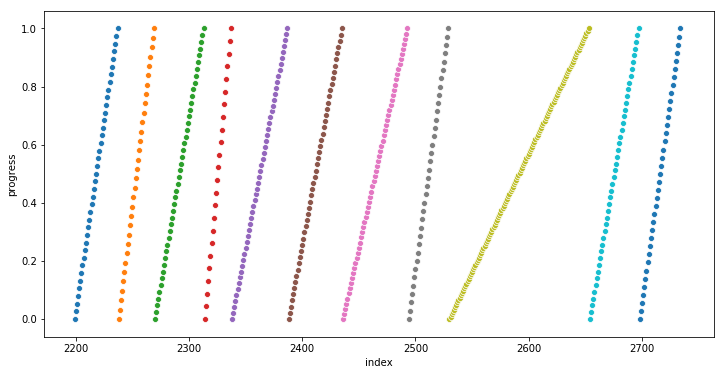

In [22]:
traj_to_plot = progress_data[progress_data.traj == 5]
plot.traj_progress(traj_to_plot)

We can see that the majority of the points that are removed are taken from the start of trajectories, which makes sense since the bus has a lot of dwell time and slow speed in the beginning. We also see a huge problem with the first route. The buss has a _massive_ dwell time on this point, more than half the time spent on the segment. This makes predictions very hard.

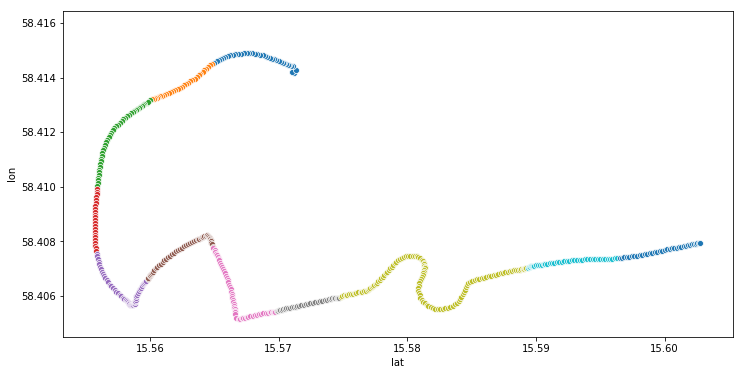

In [23]:
plot.traj_segments(traj_to_plot)

## Enforce smoothness
A property that we want from the synchroinisation GP that we will train is for it to be a smooth mapping with respect to spatial progress, that is, we want regions that are close progressionwise in the functions domain to be close in its codomain. This is not something a GP guarantees at all, so to force it to learn something closer to what we want the data is duplicated with a small offset orthogonal to progression. We call these data points support data points, and they are saved in their own data set.

This is meaningful only for training data, so at this point we split the data into train and test sets.

In [25]:
n_trajs = len(filtered_data.traj.unique())
n_train = round(n_trajs*0.8)
train_ixs = frozenset(np.random.randint(0, n_trajs-1, n_train))

train_data = filtered_data[filtered_data.traj.transform(lambda x: x in train_ixs)]
test_data = filtered_data[filtered_data.traj.transform(lambda x: x not in train_ixs)]
train_data.to_pickle('train.pkl')
test_data.to_pickle('test.pkl')

Data processed in 3.979203939437866  seconds


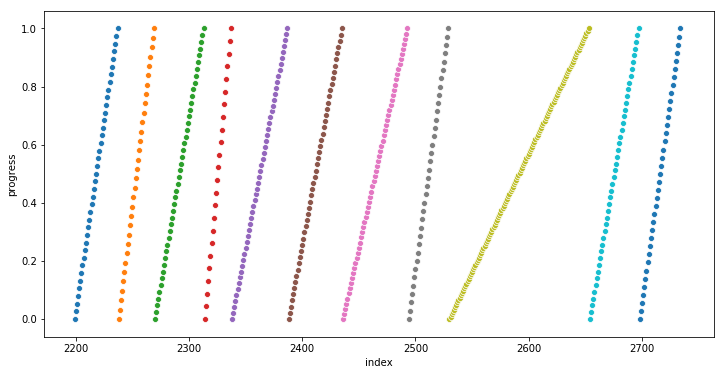

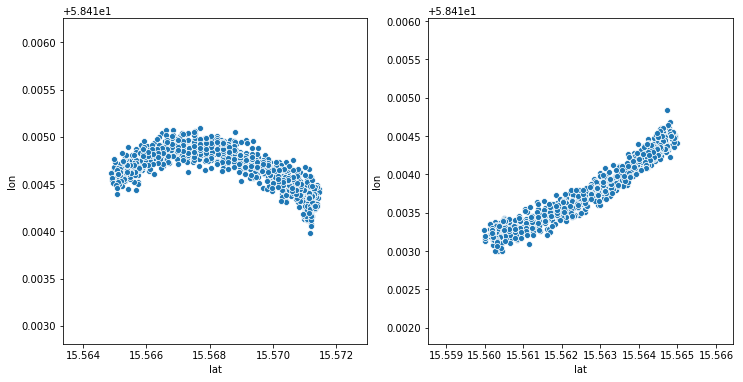

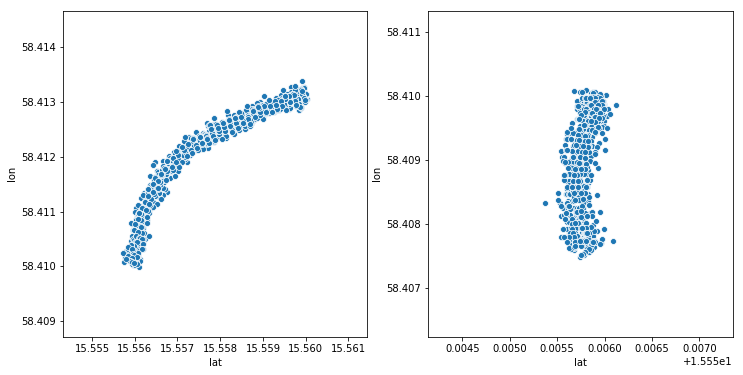

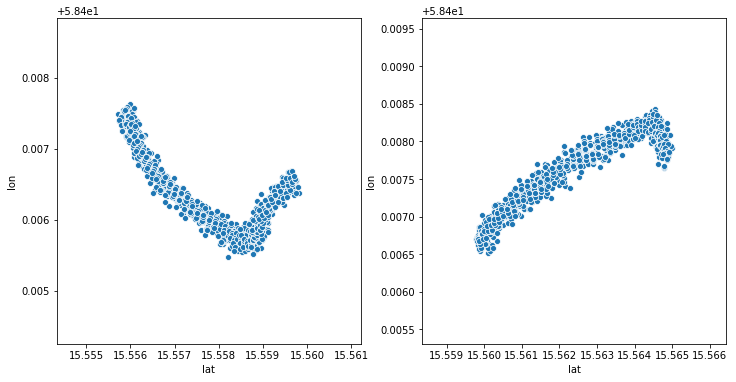

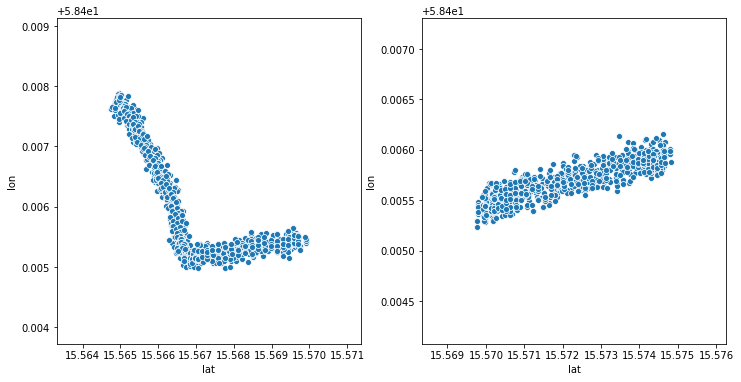

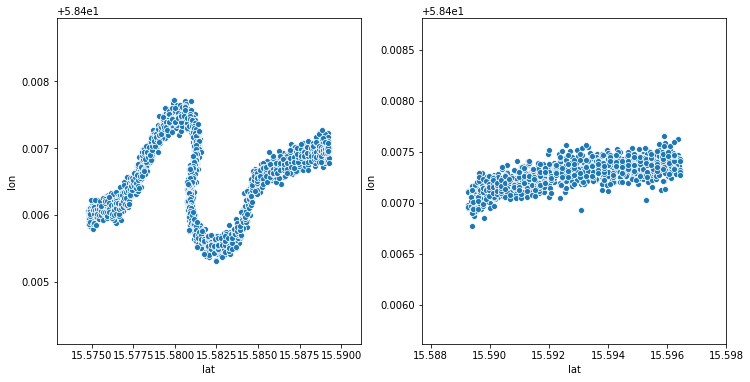

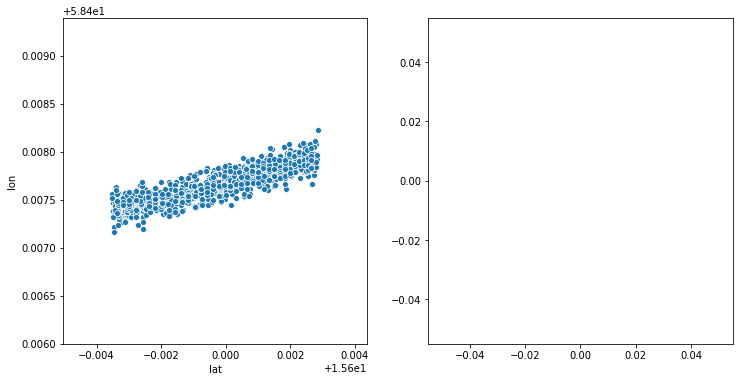

In [27]:
from numpy.linalg import norm
tmp_data = []
N = train_data.shape[0]
t0 = time.time()
d = 5 # amount of random draws

def move_to(data, lat, lon):
    data.lat = lat
    data.lon = lon
    return data

for n in range(N-1):
    cur = train_data.iloc[n]
    nxt = train_data.iloc[n+1]
    d_lat = nxt.lat - cur.lat
    d_lon = nxt.lon - cur.lon
    u = np.array([-d_lon, d_lat]) # orthogonal to progression 
    u = u/norm(u)
    
    v = np.array([cur.lat, cur.lon]) # current data point position
    sigma = 9e-5 # taken by simply looking at the results for something that looks decent
    draws = np.random.normal(0, sigma, d)
    support_latlon = [v + u*draw for draw in draws]
    
    support_data = [move_to(cur.copy(), lat, lon) for lat, lon in support_latlon]
    if [x for x in support_latlon if isnan(x[0])]:
        print(cur)
        print(nxt)
        
    tmp_data = tmp_data + support_data
    
support_data = pd.DataFrame(tmp_data)
support_data.to_pickle('support.pkl')

elapsed = time.time() - t0
print("Data processed in", elapsed, " seconds")

traj_plot_n = 5
traj_to_plot = progress_data[progress_data.traj == traj_plot_n]
sup_to_plot = support_data[support_data.traj == traj_plot_n]
plot.traj_progress(traj_to_plot)
plot.traj_segment_grid(support_data, 'lat', 'lon')